Note: This notebook requires `facetscales` which could be installed by running `devtools::install_github("zeehio/facetscales")` in R

In [1]:
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(scales)
%R library(facetscales)

import pandas as pd
import numpy as np

In [2]:
def pd2r(df):
    # For all columns with dtype = object (i.e. mixed dtypes)
    # Replace all NA's and NaN's with None
    df.loc[:, df.dtypes == object] = df.loc[:, df.dtypes == object].where((pd.notnull(df)), None)
    return df

Load the NBA POTW dataset

In [3]:
nba_potw = pd2r(pd.read_csv('../data/raw/NBA_Player_of_the_Week.csv'))

Count the number of POTWs received by each player per season and rename `Season short` to `Year`

In [4]:
nba_potw_agg = (nba_potw.groupby(['Player', 'Season short'])[['Date']].count().reset_index()
                .rename(columns = {'Season short': 'Year', 'Date': 'Potw_Count'}))

Load the NBA Player Statistics dataset

In [5]:
nba_player_stats = pd2r(pd.read_csv('../data/scraped/NBA_Player_Stats.csv'))

Join the NBA POTW and Player Statistics datasets and insert 0 for `Potw_Count` for players who did not received POTW for the season

In [6]:
nba_player = pd.merge(left = nba_player_stats, right = nba_potw_agg, on = ['Player', 'Year'], how = 'left')
nba_player.Potw_Count = nba_player.Potw_Count.where((pd.notnull(nba_player.Potw_Count)), 0)

Rename columns with `%` to avoid errors and calculate the mean statistics for the group of players who recieved POTW and those who did not

In [7]:
nba_player['MP_Prct'] = nba_player['MP'] / 48
nba_player['eFG_Prct'] = nba_player['eFG%']
nba_player['FT_Prct'] = nba_player['FT%']
nba_player['isPotw'] = np.where(nba_player['Potw_Count'] > 0, 'Yes', 'No')
nba_player_potw = (nba_player.groupby(['Year', 'isPotw'])[['G', 'MP_Prct', 'eFG_Prct', 'TRB', 'AST', 'STL']]
                   .mean().reset_index())

Only consider data after the 1989 - 1990 season to align with the Salary dataset

In [8]:
nba_player_potw = nba_player_potw.loc[nba_player_potw.Year > 1990]

Stack the data and rename columns

In [9]:
nba_player_df = (nba_player_potw.set_index(['Year', 'isPotw']).stack()
                 .reset_index().rename(columns = {'level_2': 'Stat', 0: 'Val'}))

Pipe data frame into R

In [10]:
%R -i nba_player_df

Draw `ggplot`

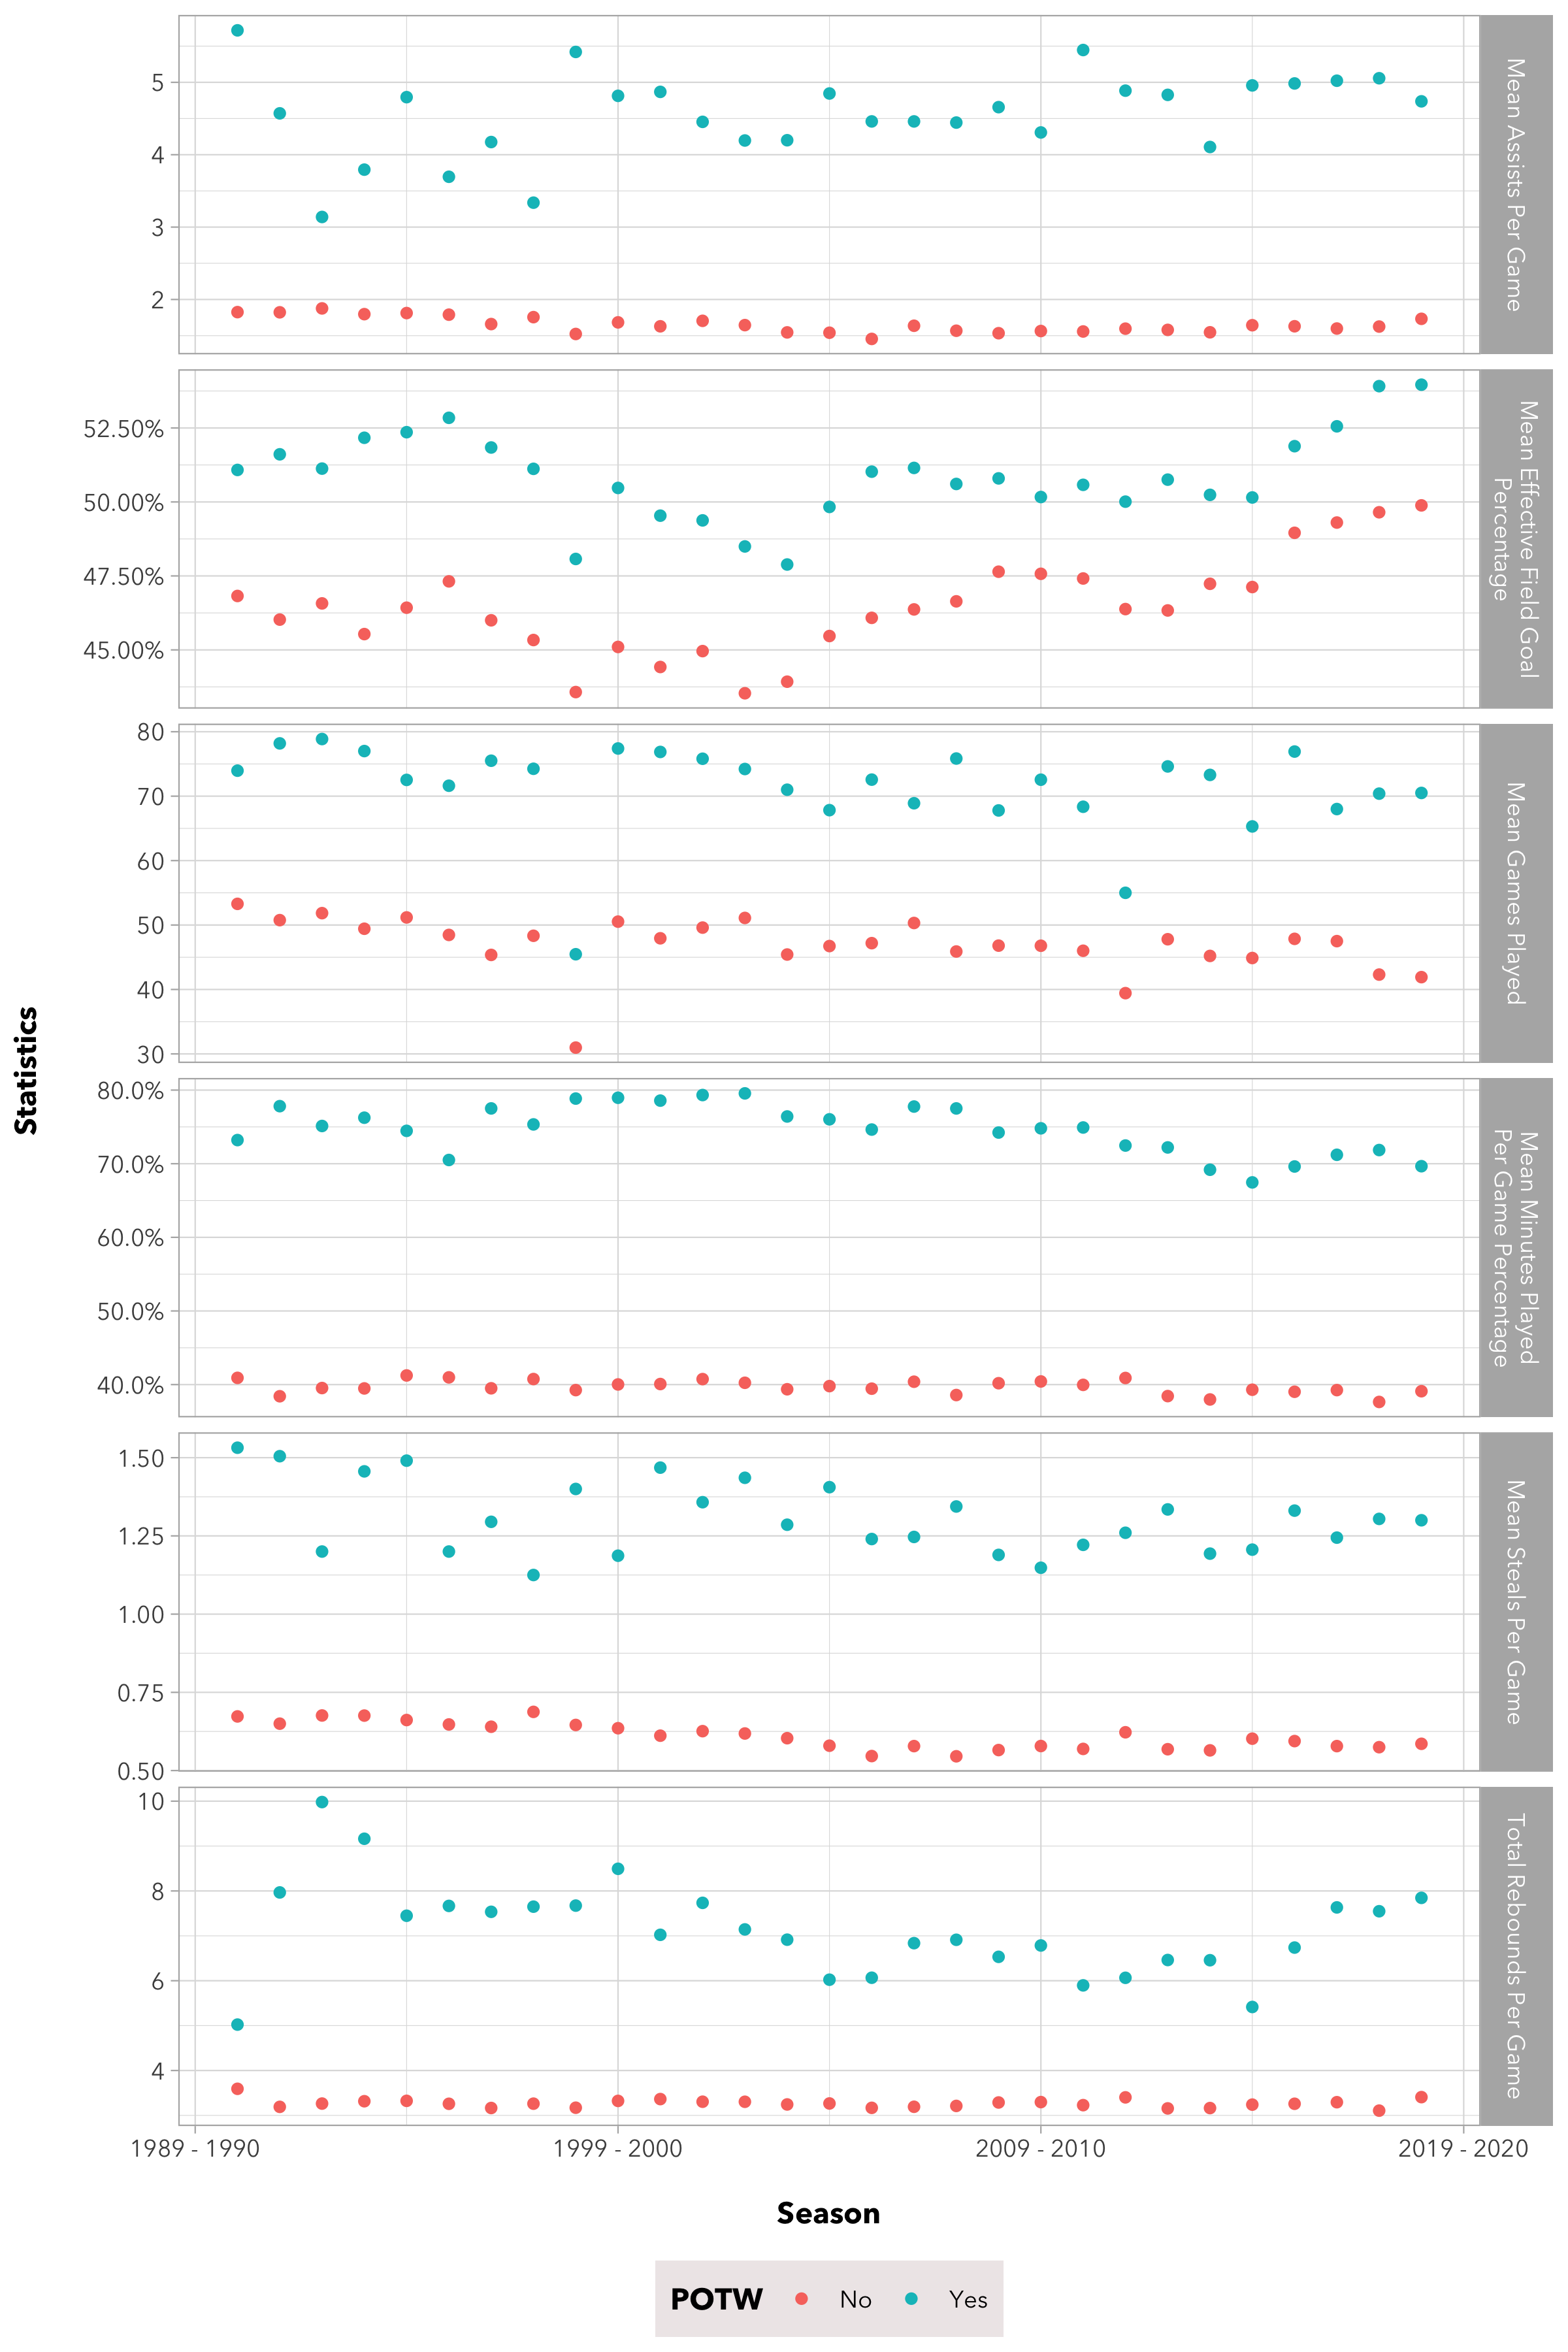

In [11]:
%%R -w 8 -h 12 --units in -r 300
season <- function(x) {
    paste(x - 1, '-', x)
}

scales_y <- list(
    G = scale_y_continuous(),
    MP_Prct = scale_y_continuous(labels = percent),
    eFG_Prct = scale_y_continuous(labels = percent),
    TRB = scale_y_continuous(),
    AST = scale_y_continuous(),
    STL = scale_y_continuous()
)
facet_labels <- c(
    G = 'Mean Games Played',
    MP_Prct = 'Mean Minutes Played\nPer Game Percentage',
    eFG_Prct = 'Mean Effective Field Goal\nPercentage',
    TRB = 'Total Rebounds Per Game',
    AST = 'Mean Assists Per Game',
    STL = 'Mean Steals Per Game'
)

ggplot() + 
geom_point(aes(x = Year, y = Val, color = isPotw), data = nba_player_df) +
facet_grid_sc(rows = vars(Stat), scales = list(y = scales_y), labeller = as_labeller(facet_labels)) +
scale_x_continuous(name = '\nSeason', label = season) +
scale_color_discrete(name = 'POTW') +
ylab('Statistics\n') +
theme_light() +
theme(text = element_text(family = 'Avenir Next'),
      axis.title = element_text(face = 'bold'),
      legend.title = element_text(face = 'bold'),
      legend.position = 'bottom',
      legend.background = element_rect(size = 0, fill = 'snow2'),
      legend.key = element_rect(fill = 'snow2'))